# Import Libraries

In [1]:
# Import all required libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import warnings
import gc
import yaml

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# YOLO
from ultralytics import YOLO

# Suppress warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully")

 All libraries imported successfully


In [2]:
# Define all paths (relative to notebooks/ folder)
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('D:\Aerial_Object_Detection\data\classification')))
DATA_PATH = os.path.join(BASE_DIR, "data")
CLASS_PATH = os.path.join(DATA_PATH, "classification")
DETECT_PATH = os.path.join(DATA_PATH, "detection")
MODEL_PATH = os.path.join(BASE_DIR, "models")

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# Create directories
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(f"{MODEL_PATH}/classification", exist_ok=True)
os.makedirs(f"{MODEL_PATH}/detection", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

print(f"  Paths configured:")
print(f"  Data: {DATA_PATH}")
print(f"  Models: {MODEL_PATH}")

  Paths configured:
  Data: D:\Aerial_Object_Detection\data
  Models: D:\Aerial_Object_Detection\models


In [3]:
# Verify all required folders exist
print(" Verifying dataset structure...")

required_folders = [
    f"{CLASS_PATH}/TRAIN/bird",
    f"{CLASS_PATH}/TRAIN/drone",
    f"{CLASS_PATH}/VALID/bird",
    f"{CLASS_PATH}/VALID/drone",
    f"{CLASS_PATH}/TEST/bird",
    f"{CLASS_PATH}/TEST/drone",
    f"{DETECT_PATH}/train/images",
    f"{DETECT_PATH}/valid/images",
    f"{DETECT_PATH}/test/images"
]

missing = []
for folder in required_folders:
    if not os.path.exists(folder):
        missing.append(folder)

if missing:
    print(" Missing folders:")
    for f in missing:
        print(f"  - {f}")
else:
    print(" All dataset folders found")
    
# Count images
print("\n Dataset counts:")
for split in ['TRAIN', 'VALID', 'TEST']:
    path = os.path.join(CLASS_PATH, split)
    bird_count = len(os.listdir(os.path.join(path, 'bird')))
    drone_count = len(os.listdir(os.path.join(path, 'drone')))
    print(f"  {split}: {bird_count} birds, {drone_count} drones")

 Verifying dataset structure...
 All dataset folders found

 Dataset counts:
  TRAIN: 1414 birds, 1248 drones
  VALID: 217 birds, 225 drones
  TEST: 121 birds, 94 drones


# Visualize Sample Images

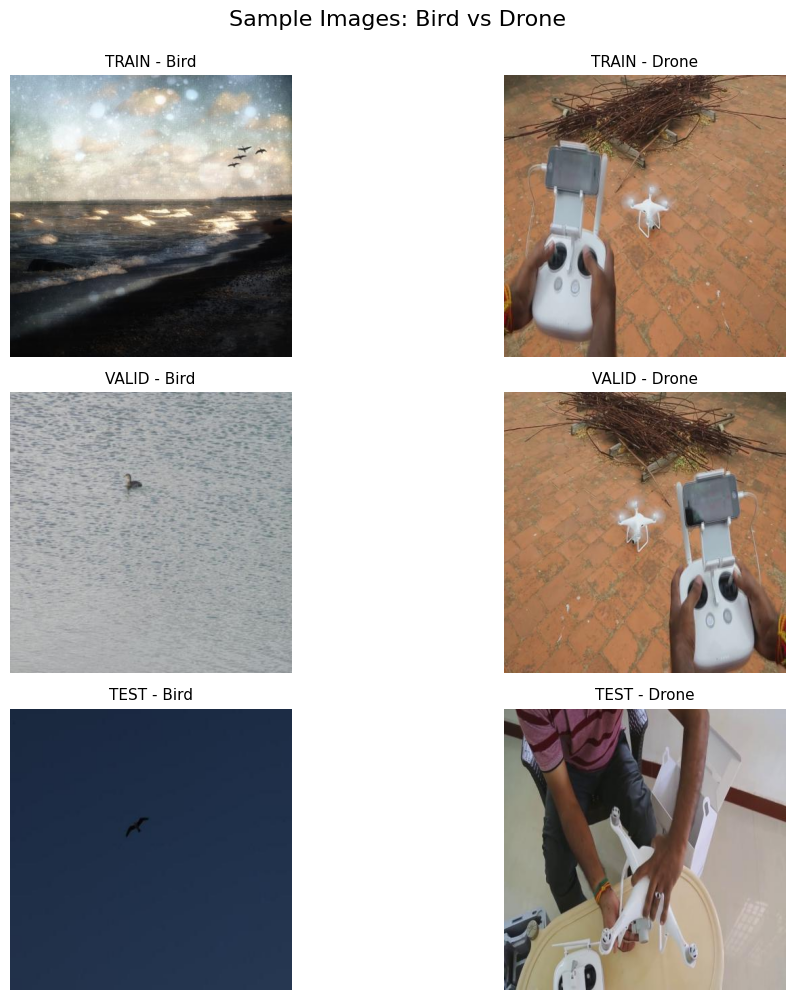

 Sample visualization saved to outputs/samples.png


In [4]:
# Visualize sample images from each class
def visualize_samples():
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    fig.suptitle('Sample Images: Bird vs Drone', fontsize=16, y=0.995)
    
    for idx, split in enumerate(['TRAIN', 'VALID', 'TEST']):
        for j, label in enumerate(['bird', 'drone']):
            path = os.path.join(CLASS_PATH, split, label)
            sample = os.listdir(path)[0]
            img = Image.open(os.path.join(path, sample))
            axes[idx, j].imshow(img)
            axes[idx, j].set_title(f'{split} - {label.title()}', fontsize=11)
            axes[idx, j].axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/samples.png', dpi=120, bbox_inches='tight')
    plt.show()
    print(" Sample visualization saved to outputs/samples.png")

visualize_samples()

#  Create Data Generators

In [5]:
# Create data generators for training
def create_generators():
    # Training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Validation/Test data without augmentation
    val_test_datagen = ImageDataGenerator(rescale=1.0/255)
    
    # Train generator
    train_gen = train_datagen.flow_from_directory(
        os.path.join(CLASS_PATH, 'TRAIN'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        seed=42
    )
    
    # Validation generator
    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(CLASS_PATH, 'VALID'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    # Test generator
    test_gen = val_test_datagen.flow_from_directory(
        os.path.join(CLASS_PATH, 'TEST'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    print(f"Generators created successfully")
    print(f"Classes: {train_gen.class_indices}")
    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = create_generators()

Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Generators created successfully
Classes: {'bird': 0, 'drone': 1}


# Build Custom CNN Model

In [6]:
# Define Custom CNN architecture
def build_custom_cnn():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=IMG_SIZE + (3,)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

custom_cnn = build_custom_cnn()
print(" Custom CNN built")
custom_cnn.summary()

 Custom CNN built


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 13,236,929 (50.49 MB)

 Trainable params: 13,235,457 (50.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

# Build Transfer Learning Model

In [7]:
# Define ResNet50 transfer learning model
def build_transfer_model():
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

transfer_model = build_transfer_model()
print(" ResNet50 Transfer Model built")
transfer_model.summary()

 ResNet50 Transfer Model built


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

# Define Training Callbacks

In [8]:
# Define callbacks for both models
def get_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f'{MODEL_PATH}/classification/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]

print(" Callbacks configured")

 Callbacks configured


# Train Custom CNN

TRAINING CUSTOM CNN
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6501 - loss: 0.8991 - precision: 0.6326 - recall: 0.6353
Epoch 1: val_accuracy improved from None to 0.50905, saving model to D:\Aerial_Object_Detection\models/classification/custom_cnn_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.6439 - loss: 0.8144 - precision: 0.6216 - recall: 0.6146 - val_accuracy: 0.5090 - val_loss: 1.8713 - val_precision: 0.5090 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6771 - loss: 0.6700 - precision: 0.6575 - recall: 0.6494
Epoch 2: val_accuracy improved from 0.50905 to 0.65837, saving model to D:\Aerial_Object_Detection\models/classification/custom_cnn_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 536s 6s/step - accuracy: 0.6916 - loss: 0.6481 - precision: 0.6799 - recall: 0.6466 - val_accuracy: 0.6584 - val_loss: 0.6117 - val_precision: 0.6480 - val_recall: 0.7200 - learning_rate: 0.0010
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7212 - loss: 0.6085 - precision: 0.7148 - recall: 0.6771
Epoch 3: val_accuracy did not improve from 0.65837
84/84 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7186 - loss: 0.5900 - precision: 0.7113 - recall: 0.6731 - val_accuracy: 0.6041 - val_loss: 0.7036 - val_precision: 0.9808 - val_recall: 0.2267 - learning_rate: 0.0010
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7457 - loss: 0.5336 - precision: 0.7597 - recall: 0.6968 
Epoch 4: val_accuracy improved from 0.65837 to 0.67421, saving model to D:\Aerial_Object_Detection\models/classification/custom_cnn_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1562s 19s/step - accuracy: 0.7588 - loss: 0.5267 - precision: 0.7542 - recall: 0.7204 - val_accuracy: 0.6742 - val_loss: 0.7335 - val_precision: 0.9355 - val_recall: 0.3867 - learning_rate: 0.0010
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7820 - loss: 0.4782 - precision: 0.7754 - recall: 0.7597
Epoch 5: val_accuracy did not improve from 0.67421

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
84/84 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.7682 - loss: 0.4937 - precision: 0.7530 - recall: 0.7524 - val_accuracy: 0.5090 - val_loss: 0.9149 - val_precision: 0.9000 - val_recall: 0.0400 - learning_rate: 0.0010
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7921 - loss: 0.4445 - precision: 0.7872 - recall: 0.7656
Epoch 6: val_accuracy improved from 0.67421 to 0.70588, saving model to D:\Aerial_Object_Detection\models/classification/custom_cnn_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.7874 - loss: 0.4510 - precision: 0.7800 - recall: 0.7612 - val_accuracy: 0.7059 - val_loss: 0.5736 - val_precision: 0.9439 - val_recall: 0.4489 - learning_rate: 5.0000e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8065 - loss: 0.4206 - precision: 0.8001 - recall: 0.7931
Epoch 7: val_accuracy improved from 0.70588 to 0.80317, saving model to D:\Aerial_Object_Detection\models/classification/custom_cnn_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.8174 - loss: 0.4037 - precision: 0.8083 - recall: 0.8005 - val_accuracy: 0.8032 - val_loss: 0.4621 - val_precision: 0.8350 - val_recall: 0.7644 - learning_rate: 5.0000e-04
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8277 - loss: 0.3924 - precision: 0.8424 - recall: 0.7850
Epoch 8: val_accuracy did not improve from 0.80317
84/84 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.8167 - loss: 0.4143 - precision: 0.8177 - recall: 0.7837 - val_accuracy: 0.7330 - val_loss: 0.7041 - val_precision: 0.7861 - val_recall: 0.6533 - learning_rate: 5.0000e-04
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8047 - loss: 0.4362 - precision: 0.7896 - recall: 0.7670
Epoch 9: val_accuracy improved from 0.80317 to 0.82127, saving model to D:\Aerial_Object_Detection\models/classification/custom_cnn_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.8167 - loss: 0.4193 - precision: 0.8193 - recall: 0.7812 - val_accuracy: 0.8213 - val_loss: 0.4170 - val_precision: 0.8349 - val_recall: 0.8089 - learning_rate: 5.0000e-04
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8407 - loss: 0.3623 - precision: 0.8366 - recall: 0.8155
Epoch 10: val_accuracy did not improve from 0.82127
84/84 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.8306 - loss: 0.3906 - precision: 0.8274 - recall: 0.8069 - val_accuracy: 0.5724 - val_loss: 1.9074 - val_precision: 0.5459 - val_recall: 0.9511 - learning_rate: 5.0000e-04
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7544 - loss: 0.5380 - precision: 0.7392 - recall: 0.7432
Epoch 11: val_accuracy did not improve from 0.82127
84/84 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.7724 - loss: 0.5041 - precision: 0.7568 - recall: 0.7580 - val_accuracy: 0.7941 - val_loss: 0.4472 - val_precision: 0.8131 - val_recall: 0.7733 - le

84/84 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.8279 - loss: 0.3835 - precision: 0.8222 - recall: 0.8077 - val_accuracy: 0.8439 - val_loss: 0.3573 - val_precision: 0.8545 - val_recall: 0.8356 - learning_rate: 2.5000e-04
Epoch 14/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8461 - loss: 0.3520 - precision: 0.8345 - recall: 0.8390
Epoch 14: val_accuracy did not improve from 0.84389
84/84 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.8340 - loss: 0.3640 - precision: 0.8255 - recall: 0.8189 - val_accuracy: 0.8326 - val_loss: 0.3809 - val_precision: 0.8356 - val_recall: 0.8356 - learning_rate: 2.5000e-04
Epoch 15/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8439 - loss: 0.3570 - precision: 0.8349 - recall: 0.8399
Epoch 15: val_accuracy improved from 0.84389 to 0.85068, saving model to D:\Aerial_Object_Detection\models/classification/custom_cnn_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.8358 - loss: 0.3691 - precision: 0.8226 - recall: 0.8285 - val_accuracy: 0.8507 - val_loss: 0.3589 - val_precision: 0.8219 - val_recall: 0.9022 - learning_rate: 2.5000e-04
Epoch 16/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8464 - loss: 0.3447 - precision: 0.8285 - recall: 0.8417
Epoch 16: val_accuracy did not improve from 0.85068

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
84/84 ━━━━━━━━━━━━━━━━━━━━ 568s 7s/step - accuracy: 0.8475 - loss: 0.3453 - precision: 0.8368 - recall: 0.8381 - val_accuracy: 0.8371 - val_loss: 0.3578 - val_precision: 0.8312 - val_recall: 0.8533 - learning_rate: 2.5000e-04
Epoch 17/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8471 - loss: 0.3445 - precision: 0.8382 - recall: 0.8254
Epoch 17: val_accuracy did not improve from 0.85068
84/84 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.8482 - loss: 0.3493 - precision: 0.8403 - recall: 0.8349 - val_accurac

84/84 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.8655 - loss: 0.3143 - precision: 0.8571 - recall: 0.8558 - val_accuracy: 0.8665 - val_loss: 0.3382 - val_precision: 0.8458 - val_recall: 0.9022 - learning_rate: 1.2500e-04
Epoch 20/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8593 - loss: 0.3260 - precision: 0.8591 - recall: 0.8422
Epoch 20: val_accuracy did not improve from 0.86652
84/84 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8629 - loss: 0.3230 - precision: 0.8518 - recall: 0.8566 - val_accuracy: 0.8439 - val_loss: 0.3564 - val_precision: 0.8277 - val_recall: 0.8756 - learning_rate: 1.2500e-04
Epoch 21/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8771 - loss: 0.2914 - precision: 0.8771 - recall: 0.8637
Epoch 21: val_accuracy did not improve from 0.86652
84/84 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.8696 - loss: 0.3064 - precision: 0.8573 - recall: 0.8662 - val_accuracy: 0.8462 - val_loss: 0.3591 - val_precision: 0.8340 - val_recall: 0.8711 - le

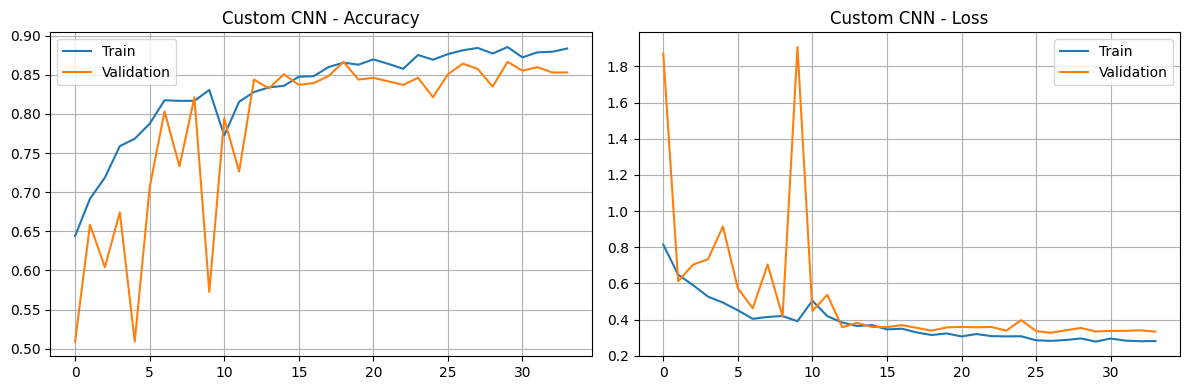

 Custom CNN training completed


In [9]:
# Train Custom CNN model


print("="*50)
print("TRAINING CUSTOM CNN")
print("="*50)

history_custom = custom_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks('custom_cnn'),
    verbose=1
)

# Save final model
custom_cnn.save(f'{MODEL_PATH}/classification/custom_cnn_final.h5')

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_custom.history['accuracy'], label='Train')
plt.plot(history_custom.history['val_accuracy'], label='Validation')
plt.title('Custom CNN - Accuracy')
plt.legend(), plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_custom.history['loss'], label='Train')
plt.plot(history_custom.history['val_loss'], label='Validation')
plt.title('Custom CNN - Loss')
plt.legend(), plt.grid(True)

plt.tight_layout()
plt.savefig('outputs/custom_cnn_curves.png')
plt.show()

# Clear memory
del custom_cnn
gc.collect()
print(" Custom CNN training completed")

# Train Transfer Learning Model

TRAINING RESNET50 TRANSFER MODEL
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5903 - loss: 0.7138 - precision_1: 0.5743 - recall_1: 0.4899 
Epoch 1: val_accuracy improved from None to 0.49095, saving model to D:\Aerial_Object_Detection\models/classification/transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1279s 15s/step - accuracy: 0.6172 - loss: 0.6760 - precision_1: 0.6108 - recall_1: 0.5056 - val_accuracy: 0.4910 - val_loss: 1.0055 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7043 - loss: 0.5795 - precision_1: 0.7156 - recall_1: 0.5961
Epoch 2: val_accuracy improved from 0.49095 to 0.49548, saving model to D:\Aerial_Object_Detection\models/classification/transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 952s 11s/step - accuracy: 0.7044 - loss: 0.5796 - precision_1: 0.7185 - recall_1: 0.6074 - val_accuracy: 0.4955 - val_loss: 0.8849 - val_precision_1: 1.0000 - val_recall_1: 0.0089 - learning_rate: 1.0000e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7132 - loss: 0.5470 - precision_1: 0.7207 - recall_1: 0.6387
Epoch 3: val_accuracy improved from 0.49548 to 0.52262, saving model to D:\Aerial_Object_Detection\models/classification/transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 503s 6s/step - accuracy: 0.7130 - loss: 0.5542 - precision_1: 0.7184 - recall_1: 0.6378 - val_accuracy: 0.5226 - val_loss: 0.7943 - val_precision_1: 1.0000 - val_recall_1: 0.0622 - learning_rate: 1.0000e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7292 - loss: 0.5342 - precision_1: 0.7173 - recall_1: 0.6619 
Epoch 4: val_accuracy improved from 0.52262 to 0.54299, saving model to D:\Aerial_Object_Detection\models/classification/transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 1597s 19s/step - accuracy: 0.7213 - loss: 0.5445 - precision_1: 0.7283 - recall_1: 0.6466 - val_accuracy: 0.5430 - val_loss: 0.9285 - val_precision_1: 1.0000 - val_recall_1: 0.1022 - learning_rate: 1.0000e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7139 - loss: 0.5440 - precision_1: 0.7210 - recall_1: 0.6395
Epoch 5: val_accuracy improved from 0.54299 to 0.69457, saving model to D:\Aerial_Object_Detection\models/classification/transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.7168 - loss: 0.5505 - precision_1: 0.7258 - recall_1: 0.6362 - val_accuracy: 0.6946 - val_loss: 0.5336 - val_precision_1: 0.6339 - val_recall_1: 0.9467 - learning_rate: 1.0000e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7286 - loss: 0.5384 - precision_1: 0.7632 - recall_1: 0.6433
Epoch 6: val_accuracy improved from 0.69457 to 0.79638, saving model to D:\Aerial_Object_Detection\models/classification/transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 991s 12s/step - accuracy: 0.7224 - loss: 0.5373 - precision_1: 0.7359 - recall_1: 0.6362 - val_accuracy: 0.7964 - val_loss: 0.4729 - val_precision_1: 0.8027 - val_recall_1: 0.7956 - learning_rate: 1.0000e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7348 - loss: 0.5333 - precision_1: 0.7262 - recall_1: 0.6584
Epoch 7: val_accuracy did not improve from 0.79638
84/84 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.7363 - loss: 0.5322 - precision_1: 0.7464 - recall_1: 0.6627 - val_accuracy: 0.6855 - val_loss: 0.6488 - val_precision_1: 0.9300 - val_recall_1: 0.4133 - learning_rate: 1.0000e-04
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7293 - loss: 0.5254 - precision_1: 0.7303 - recall_1: 0.6623
Epoch 8: val_accuracy did not improve from 0.79638
84/84 ━━━━━━━━━━━━━━━━━━━━ 601s 7s/step - accuracy: 0.7318 - loss: 0.5344 - precision_1: 0.7384 - recall_1: 0.6627 - val_accuracy: 0.6176 - val_loss: 0.6834 - val_precision_1: 0.572

84/84 ━━━━━━━━━━━━━━━━━━━━ 803s 9s/step - accuracy: 0.7449 - loss: 0.5090 - precision_1: 0.7575 - recall_1: 0.6707 - val_accuracy: 0.8303 - val_loss: 0.4226 - val_precision_1: 0.8676 - val_recall_1: 0.7867 - learning_rate: 2.5000e-05
Epoch 14/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7515 - loss: 0.4953 - precision_1: 0.7549 - recall_1: 0.6815
Epoch 14: val_accuracy did not improve from 0.83032
84/84 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7464 - loss: 0.5072 - precision_1: 0.7588 - recall_1: 0.6731 - val_accuracy: 0.8054 - val_loss: 0.4238 - val_precision_1: 0.8757 - val_recall_1: 0.7200 - learning_rate: 2.5000e-05
Epoch 15/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7396 - loss: 0.5241 - precision_1: 0.7681 - recall_1: 0.6478
Epoch 15: val_accuracy did not improve from 0.83032
84/84 ━━━━━━━━━━━━━━━━━━━━ 699s 8s/step - accuracy: 0.7468 - loss: 0.5207 - precision_1: 0.7652 - recall_1: 0.6635 - val_accuracy: 0.7353 - val_loss: 0.5061 - val_precision_1: 0.

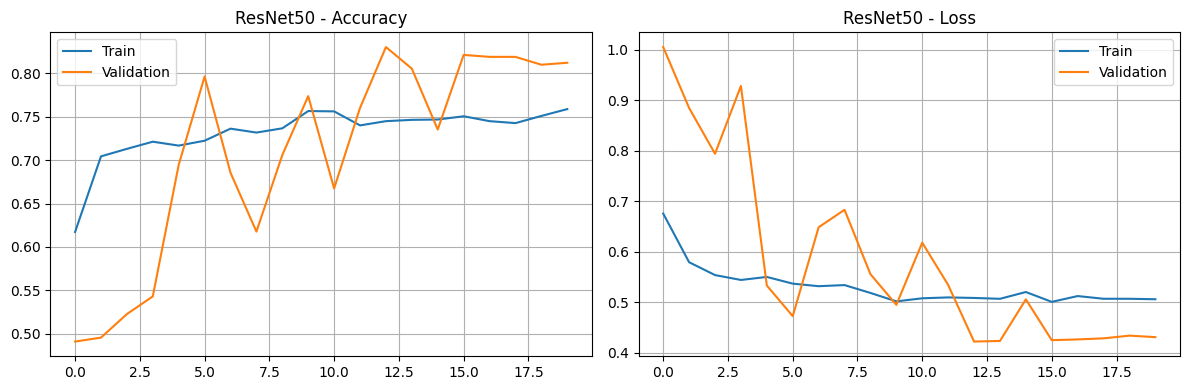

 ResNet50 training completed


In [10]:
# Train ResNet50 Transfer Learning model

print("TRAINING RESNET50 TRANSFER MODEL")

history_transfer = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=get_callbacks('transfer_resnet50'),
    verbose=1
)

# Save final model
transfer_model.save(f'{MODEL_PATH}/classification/transfer_resnet50_final.h5')

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Train')
plt.plot(history_transfer.history['val_accuracy'], label='Validation')
plt.title('ResNet50 - Accuracy')
plt.legend(), plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Train')
plt.plot(history_transfer.history['val_loss'], label='Validation')
plt.title('ResNet50 - Loss')
plt.legend(), plt.grid(True)

plt.tight_layout()
plt.savefig('outputs/resnet50_curves.png')
plt.show()

# Clear memory
del transfer_model
gc.collect()
print(" ResNet50 training completed")

# Evaluate Models

EVALUATING Custom_CNN


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 570ms/step

Classification Report:
              precision    recall  f1-score   support

        Bird       0.91      0.88      0.89       121
       Drone       0.85      0.89      0.87        94

    accuracy                           0.88       215
   macro avg       0.88      0.88      0.88       215
weighted avg       0.89      0.88      0.88       215



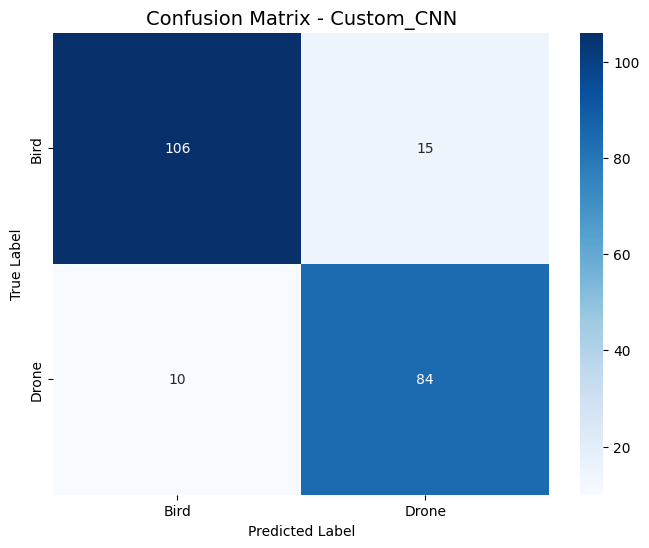

EVALUATING ResNet50_Transfer


7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step

Classification Report:
              precision    recall  f1-score   support

        Bird       0.80      0.87      0.83       121
       Drone       0.81      0.72      0.76        94

    accuracy                           0.80       215
   macro avg       0.81      0.80      0.80       215
weighted avg       0.81      0.80      0.80       215



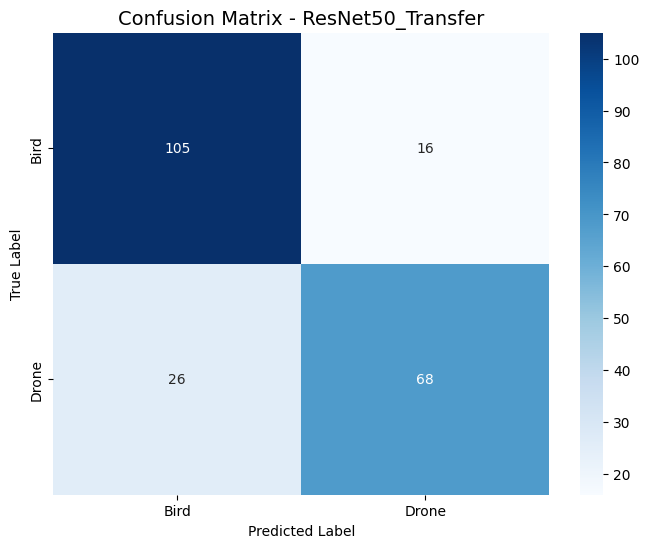


FINAL COMPARISON
Accuracy   | Custom CNN: 0.8837 | ResNet50: 0.8047 | Winner: Custom CNN
Precision  | Custom CNN: 0.8485 | ResNet50: 0.8095 | Winner: Custom CNN
Recall     | Custom CNN: 0.8936 | ResNet50: 0.7234 | Winner: Custom CNN
F1         | Custom CNN: 0.8705 | ResNet50: 0.7640 | Winner: Custom CNN


In [14]:
# Evaluate both trained models
def evaluate_model(model_path, model_name):
    
    print(f"EVALUATING {model_name}")
    
    
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Get predictions
    test_steps = len(test_gen)
    predictions = model.predict(test_gen, steps=test_steps, verbose=1)
    pred_labels = (predictions > 0.5).astype(int).flatten()
    true_labels = test_gen.classes
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(true_labels, pred_labels, 
                                 target_names=['Bird', 'Drone'], output_dict=True)
    print(classification_report(true_labels, pred_labels, target_names=['Bird', 'Drone']))
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Bird', 'Drone'], yticklabels=['Bird', 'Drone'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'outputs/{model_name}_confusion.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': report['accuracy'],
        'precision': report['Drone']['precision'],
        'recall': report['Drone']['recall'],
        'f1': report['Drone']['f1-score']
    }

# Evaluate Custom CNN
custom_metrics = evaluate_model(f'{MODEL_PATH}/classification/custom_cnn_best.h5', 'Custom_CNN')

# Evaluate ResNet50
transfer_metrics = evaluate_model(f'{MODEL_PATH}/classification/transfer_resnet50_best.h5', 'ResNet50_Transfer')

# Compare models
print("\n" + "="*50)
print("FINAL COMPARISON")
print("="*50)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    c_val = custom_metrics[metric]
    t_val = transfer_metrics[metric]
    winner = "Custom CNN" if c_val > t_val else "ResNet50"
    print(f"{metric.capitalize():<10} | Custom CNN: {c_val:.4f} | ResNet50: {t_val:.4f} | Winner: {winner}")

#  YOLOv8 Setup

In [13]:
# Setup YOLOv8 object detection

print("YOLOV8 OBJECT DETECTION SETUP")


# Create data.yaml
data_yaml = {
    'path': DETECT_PATH,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 2,
    'names': ['bird', 'drone']
}

yaml_path = os.path.join(DETECT_PATH, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"  data.yaml created at {yaml_path}")
print("\n Run this command in your terminal to train YOLO:")
print("   yolo task=detect mode=train model=yolov8n.pt data=data/detection/data.yaml epochs=100 imgsz=640 batch=16 project=models/detection name=aerial_detection")

YOLOV8 OBJECT DETECTION SETUP
  data.yaml created at D:\Aerial_Object_Detection\data\detection\data.yaml

 Run this command in your terminal to train YOLO:
   yolo task=detect mode=train model=yolov8n.pt data=data/detection/data.yaml epochs=100 imgsz=640 batch=16 project=models/detection name=aerial_detection
